# CS109 Project: Baseline Model
Work by Harry Xue

In [140]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pickle
from sklearn.preprocessing import Imputer
%matplotlib inline

## Load in cleaned data
Let's load in the data that we've cleaned and preprocessed.

In [199]:
# Load cleaned NCD data from pickled files
out = open('data/clean/deaths_100k.p', 'rb')
deaths_100k = pickle.load(out)
out.close()
out = open('data/clean/risk.p', 'rb')
risk_of_death = pickle.load(out)
out.close()
out = open('data/clean/crops.p', 'rb')
crops = pickle.load(out)
out.close()
out = open('data/clean/meat.p', 'rb')
meat = pickle.load(out)
out.close()

### Get Response Variables
First let's isolate some possible response variables we might want to look at:
* Deaths for 100k people in 2000 from all causes
* Risk of death for 30 year old in 2000

Note that the following analysis could naturally be extended to 2012 as well, but for this milestone we'll focus on the year 2000.

In [198]:
# Get response variables
deaths_100k_all_2000 = deaths_100k['all'][2000]
deaths_100k_cancer_2000 = deaths_100k['cancer'][2000]
deaths_100k_cardio_2000 = deaths_100k['cardio'][2000]
deaths_100k_diabetes_2000 = deaths_100k['diabetes'][2000]
deaths_100k_resp_2000 = deaths_100k['resp'][2000]

risk_of_death_2000 = risk_of_death[2000]

### Get Food Predictor Variables
Next let's get the food predictors (crop and meat data). Rather than looking at single years, let's calculate the mean for each crop/meat in the 30 years preceding the year of our response variable.

In [107]:
# TODO: Turn this process into a function later?
time_period = range(1970, 2000)

# Calculate the mean for each crop/meat over the period 1970-2000
food_1970_2000 = pd.DataFrame(index=risk_of_death.index)

for crop in crops.iterkeys():
    food_1970_2000[crop] = crops[crop][time_period].mean(axis=1)
    
for m in meat.iterkeys():
    food_1970_2000[m] = meat[m][time_period].mean(axis=1)


food_1970_2000.head()

,Ricebran Oil,Oilcrops,Plantains,"Sugar, Raw Equivalent","Beverages, Alcoholic",Roots & Tuber Dry Equiv,Vegetable Oils,Olives (including preserved),Cloves,Millet and products,...,Offals,Bovine Meat,"Molluscs, Other","Fish, Body Oil","Aquatic Animals, Others",Animal fats,Honey,"Offals, Edible",Demersal Fish,Cream
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,2.629000,NaN,14.402000,0.002333,8.539333,7.995000,0.065333,NaN,5.360333,...,9.166000,16.762667,NaN,NaN,NaN,6.513000,0.687667,9.166000,NaN,0.000000
Albania,NaN,7.044333,NaN,50.132333,3.201000,10.253333,20.501000,7.017667,NaN,NaN,...,6.729333,18.681000,0.416000,0.0,0.0,8.995000,0.488667,6.734667,0.604000,0.005333
Algeria,NaN,1.646000,0.0,69.079333,0.108667,15.592333,33.352667,1.432667,0.004667,NaN,...,3.079333,9.742333,0.001000,0.0,0.0,5.180333,0.247333,3.079333,0.950333,NaN
Angola,NaN,3.671667,NaN,26.933333,1.855000,157.302000,21.056000,NaN,0.000000,16.849333,...,3.521333,21.081000,0.000333,0.0,0.0,1.588000,5.557000,3.521333,3.859667,NaN
Argentina,NaN,1.813000,NaN,113.051667,10.766000,41.883333,35.942667,1.235333,0.000333,NaN,...,19.928000,192.834333,0.675000,0.0,0.0,10.627667,0.505000,19.933333,13.161333,0.157000


### Dropping sparse columns and rows

Unfortunately it looks like even after averaging over ten years, we still have quite a bit of NaN's. Let's try dropping the countries that are almost half NaN's:

In [108]:
# list of countries to drop due to being less than 50% full
countries_to_drop = []

for index, row in food_1970_2000.iterrows():
    if row.isnull().sum() > len(row) / 2:
        countries_to_drop.append(index)

print countries_to_drop
print "Number of countries to drop:", len(countries_to_drop)

['Bahrain', 'Belgium', 'Bhutan', 'Burundi', 'Comoros', 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eritrea', 'Libya', 'Montenegro', 'Papua New Guinea', 'Qatar', 'Serbia', 'Singapore', 'Somalia', 'South Sudan', 'Sudan', 'Syrian Arab Republic']
Number of countries to drop: 18


In [109]:
# Drop the identified countries with very sparse data
food_1970_2000_cleaned = food_1970_2000.drop(countries_to_drop)

Let's also see how many columns are very sparse (< 50% full) and consider dropping them as well if there are not too many.

In [110]:
cols_to_drop = []

# Identify sparse columns to drop
for col in food_1970_2000_cleaned.columns:
    if food_1970_2000_cleaned[col].isnull().sum() > len(food_1970_2000_cleaned[col]) / 2:
        cols_to_drop.append(col)
        
print cols_to_drop
print "Number of columns to drop:", len(cols_to_drop)

['Ricebran Oil', 'Millet and products', 'Sugar non-centrifugal', 'Molasses', 'Sugar beet', 'Sorghum and products', 'Sunflower seed', 'Sugar Crops', 'Sugar cane', 'Yams', 'Meat, Aquatic Mammals', 'Meat Meal', 'Whey']
Number of columns to drop: 13


Overall, there aren't too many columns to drop. However, unfortunately data on sugar-related products seems to be disproportionately sparse (which makes sense since very few countries have the correct conditions to grow sugar domestically). We'll drop these columns for now. 

The good news is though that we still have many columns that still contain sugar-related products even after dropping, so we should still be able to use sugar as a predictor in some form.

In [111]:
# Drop identified crops with very sparse data
food_1970_2000_cleaned = food_1970_2000_cleaned.drop(cols_to_drop, axis=1)

In [112]:
# Sanity check to see what percentage of cells are missing
print "Percentage NaN cells after dropping:", food_1970_2000_cleaned.isnull().sum().sum() / float(food_1970_2000_cleaned.shape[0] * food_1970_2000_cleaned.shape[1])

Percentage NaN cells after dropping: 0.0638031693078


### Imputation of Missing Values
Since the number of NaN cells has drastically been reduced, now let's use simple mean imputation (global average per crop) to fill them in. It may be worth investigating other methods for imputation in the future, but given the small number of NaN's now, this method should not have a huge impact on our results.

In [113]:
# Impute by mean for each column (i.e. global average per crop)
imp = Imputer(axis=1)
food_1970_2000_cleaned = pd.DataFrame(imp.fit_transform(food_1970_2000_cleaned), index=food_1970_2000_cleaned.index, columns=food_1970_2000_cleaned.columns)

In [114]:
food_1970_2000_cleaned.head()

,Oilcrops,Plantains,"Sugar, Raw Equivalent","Beverages, Alcoholic",Roots & Tuber Dry Equiv,Vegetable Oils,Olives (including preserved),Cloves,Coconuts - Incl Copra,Treenuts,...,Offals,Bovine Meat,"Molluscs, Other","Fish, Body Oil","Aquatic Animals, Others",Animal fats,Honey,"Offals, Edible",Demersal Fish,Cream
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2.629000,29.068781,14.402000,0.002333,8.539333,7.995000,0.065333,29.068781,0.015000,2.327333,...,9.166000,16.762667,29.068781,29.068781,29.068781,6.513000,0.687667,9.166000,29.068781,0.000000
Albania,7.044333,32.502693,50.132333,3.201000,10.253333,20.501000,7.017667,32.502693,0.006333,4.350000,...,6.729333,18.681000,0.416000,0.000000,0.000000,8.995000,0.488667,6.734667,0.604000,0.005333
Algeria,1.646000,0.000000,69.079333,0.108667,15.592333,33.352667,1.432667,0.004667,0.012000,1.453667,...,3.079333,9.742333,0.001000,0.000000,0.000000,5.180333,0.247333,3.079333,0.950333,25.450712
Angola,3.671667,26.325172,26.933333,1.855000,157.302000,21.056000,26.325172,0.000000,0.000000,0.401000,...,3.521333,21.081000,0.000333,0.000000,0.000000,1.588000,5.557000,3.521333,3.859667,26.325172
Argentina,1.813000,44.950187,113.051667,10.766000,41.883333,35.942667,1.235333,0.000333,0.584000,1.133000,...,19.928000,192.834333,0.675000,0.000000,0.000000,10.627667,0.505000,19.933333,13.161333,0.157000


# I. Null Model
First we fit a null model where the disease incidence in a country is the same as the global average.

# II. Linear Regression
Now let's try to predict health outcomes using the data that we've cleaned and preprocessed and simple linear regression.

## Risk of Death in 2000 as Response Variable

In [190]:
# Plots bar graph of coefficient estimates for regression model and given significance level 
def plot_sig_coeffs(fit, sig_level):
    # Filter for predictors with p-values less than provided cutoff
    significant = fit.pvalues[fit.pvalues <= sig_level]
    # Plot coefficient estimates for predictors with p < 0.1 
    fit.params[significant.index].sort_values().plot(kind="bar", 
        title="Coefficient Estimates for Predictors with p < 0.1", 
        )

In [191]:
# Fit linear model with risk of death in 2000 as response variable
risk_2000_model = sm.OLS(risk_of_death_2000.drop(countries_to_drop), food_1970_2000_cleaned)
risk_2000_results = risk_2000_model.fit()
print(risk_2000_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   2000   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     44.72
Date:                Mon, 28 Nov 2016   Prob (F-statistic):           9.43e-28
Time:                        22:47:09   Log-Likelihood:                -339.98
No. Observations:                 154   AIC:                             898.0
Df Residuals:                      45   BIC:                             1229.
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Oilcrops  

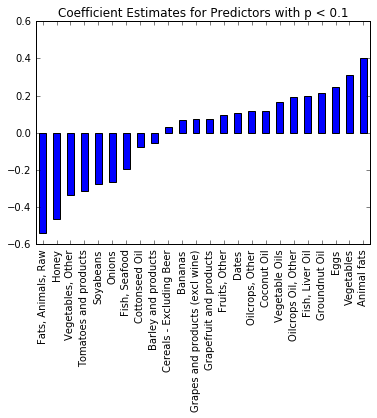

In [194]:
# Set p <= 0.1 to display borderline significant results as well
plot_sig_coeffs(risk_2000_results, 0.1)

### Interpretation
### Statistical Issues
From the summary of the fit, we see that multicollinearity is an issue as expected, so moving forward we will have to address that with variable selection- lasso regression will probably be a good way of dealing with that. Other standard regression diagnostics, such as checking for normality of residuals, homoskedasticity and nonlinearity should be performed as well when fine-tuning our eventual models.

### Categorization Issues
From the graph, it's apparent that an issue we have is the categorization of food items from the FAO database. For example, FAO has separate categories for raw animal fats and animal fats (which have opposite signs for coefficient estimates), which does not make a lot of sense since we are dealing with food for human consumption. Several other categories- vegetables as opposed to vegetables, other are problematic as well.

Let's fit linear models for the other response variables in the year 2000.

## Deaths per 100k from All Causes

In [210]:
# deaths_100k_all_2000_model = sm.OLS(deaths_100k_all_2000.drop(countries_to_drop), food_1970_2000_cleaned)
print deaths_100k_all_2000[deaths_100k_all_2000.drop(countries_to_drop).index != food_1970_2000_cleaned.index]
# deaths_100k_all_2000_results = deaths_100k_all_2000_model.fit()
# print(deaths_100k_all_2000.summary())
# plot_sig_coeffs(deaths_100k_all_2000_results, 0.1)

Country
Brunei Darussalam           484.1
Bulgaria                    764.0
Burkina Faso                685.3
Burundi                     681.9
Cabo Verde                  607.6
Cambodia                    472.3
Cameroon                    660.9
Canada                      404.5
Central African Republic    554.0
Chad                        709.6
Chile                       431.9
China                       660.9
Name: 2000, dtype: float64


/Users/harryxue/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:227: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 172 but corresponding boolean dimension is 154
  return self.values[slicer]
/Users/harryxue/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 172 but corresponding boolean dimension is 154
  result = getitem(key)


In [ ]:

deaths_100k_all_2000 = deaths_100k['all'][2000]
deaths_100k_cancer_2000 = deaths_100k['cancer'][2000]
deaths_100k_cardio_2000 = deaths_100k['cardio'][2000]
deaths_100k_diabetes_2000 = deaths_100k['diabetes'][2000]
deaths_100k_resp_2000 = deaths_100k['resp'][2000]